In [1]:
import numpy as np
import random


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import quantstats as qs
import pandas as pd

In [3]:
from stable_baselines3 import PPO
import gymnasium as gym 

df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)


def make_stock_env(start_index=start_index, end_index=end_index, window_size=window_size):
    return gym.make(
    'stocks-v0',
    df=STOCKS_GOOGL,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

In [4]:
env = make_stock_env()
print("observation_space:", env.observation_space)


observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [5]:
model_name = 'stocks'

In [6]:
train = False

if train:
    # Instantiate the agent
    model = PPO(
        "MlpPolicy",
        env,
        n_steps=1024,
        batch_size=64,
        n_epochs=4,
        gamma=0.999,
        gae_lambda=0.98,
        ent_coef=0.01,
        verbose=10,
        device='mps'
    )

    # Train the agent
    steps = 2e6
    model.learn(total_timesteps=steps, progress_bar=True)
    model.save(model_name)

In [7]:
def print_results(model):
    eval_env = Monitor(make_stock_env())
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
    print(f"mean_reward= {mean_reward} +/- {std_reward}", end="\r")

In [8]:
device = 'mps'
model = PPO.load(model_name,device=device)

In [9]:
print_results(model)

In [10]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 1573, <Actions.Buy: 1>: 751}
info: {'total_reward': 92.25178527832031, 'total_profit': 0.00039978698266025716, 'position': <Positions.Short: 0>}


In [11]:
old_profit = 0.0002188696477372883
new_profit = info['total_profit']
new_profit - old_profit

0.00018091733492296886

In [18]:
env.unwrapped.__dict__.keys()

dict_keys(['frame_bound', 'render_mode', 'df', 'window_size', 'prices', 'signal_features', 'shape', 'action_space', 'observation_space', '_start_tick', '_end_tick', '_truncated', '_current_tick', '_last_trade_tick', '_position', '_position_history', '_total_reward', '_total_profit', '_first_rendering', 'history', 'trade_fee_bid_percent', 'trade_fee_ask_percent', 'spec', '_np_random'])

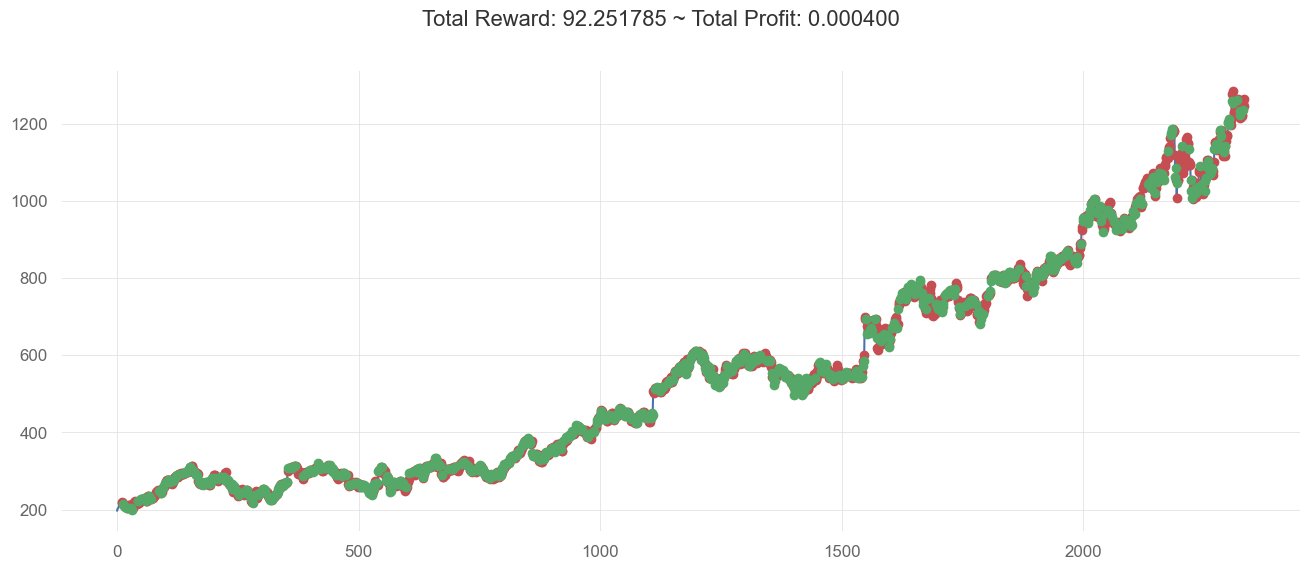

In [12]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [13]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (2335,)
> signal_features.shape: (2335, 2)
> max_possible_profit: 346146.2024750656

env information:
> shape: (10, 2)
> df.shape: (2335, 6)
> prices.shape: (2335,)
> signal_features.shape: (2335, 2)
> max_possible_profit: 346146.2024750656


In [14]:
import warnings 
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [15]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.html(returns, output='SB3_a2c_quantstats.html')

In [16]:
from IPython.display import display, HTML

with open('SB3_a2c_quantstats.html','r') as f:
    display(HTML(f.read()))